In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

DIR = '/kaggle/input/aaa-project-search/'

/kaggle/input/aaa-project-search/search_relevance_dataset_v1.hdf


Load data with pandas and look some info about content + the first 3 rows + some descriptive stats

In [2]:
df = pd.read_hdf(DIR + 'search_relevance_dataset_v1.hdf', 'table')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161429 entries, 0 to 161428
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   query_id           161429 non-null  int64  
 1   query_text         161429 non-null  object 
 2   query_category_id  73656 non-null   float64
 3   query_microcat_id  52971 non-null   float64
 4   query_location_id  25096 non-null   float64
 5   item_id            161429 non-null  int64  
 6   title              161429 non-null  object 
 7   description        161429 non-null  object 
 8   keywords           161429 non-null  object 
 9   target             161429 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 13.5+ MB


In [3]:
df.head(3)

,query_id,query_text,query_category_id,query_microcat_id,query_location_id,item_id,title,description,keywords,target
0,274025,2108 ссср,NaN,NaN,NaN,964140459,Советские бутыли канистры 60-80-х СССР ваз газ...,Для ценителей и понимающих.\n\nПодробные фотог...,стопсфинксstop,0
1,274025,2108 ссср,NaN,NaN,NaN,990433426,Ваз 2108 СССР цвет салатовый 1/43 идеальный,красивый салатовый цвет\nвсе детали в наличии\...,модель,1
2,274025,2108 ссср,NaN,NaN,NaN,994402610,Модели советских машин ваз 2102 почта М 1/43 №10,Продается модель автомобиля ВАЗ 2102 почта . ...,модель,1


In [4]:
df.describe(include='all')

,query_id,query_text,query_category_id,query_microcat_id,query_location_id,item_id,title,description,keywords,target
count,161429.000000,161429,73656.000000,52971.000000,25096.000000,1.614290e+05,161429,161429,161429,161429.000000
unique,NaN,10520,NaN,NaN,NaN,NaN,118176,147680,8464,NaN
top,NaN,коляска,NaN,NaN,NaN,NaN,Квадрокоптер,,стопсфинксstop,NaN
freq,NaN,632,NaN,NaN,NaN,NaN,490,437,10837,NaN
mean,187915.967131,NaN,41.847575,1217.489815,639059.620975,1.307167e+09,NaN,NaN,NaN,0.525748
std,175735.310400,NaN,37.591939,6919.254680,39398.498174,4.329072e+08,NaN,NaN,NaN,0.499338
min,4.000000,NaN,1.000000,2.000000,107620.000000,1.000990e+05,NaN,NaN,NaN,0.000000
25%,16832.000000,NaN,10.000000,21.000000,637640.000000,9.875730e+08,NaN,NaN,NaN,0.000000
50%,235276.000000,NaN,24.000000,50.000000,637640.000000,1.308105e+09,NaN,NaN,NaN,1.000000
75%,275754.000000,NaN,84.000000,267.000000,653240.000000,1.762681e+09,NaN,NaN,NaN,1.000000


Check if item_id-title mapping is one to one: if yes - drop it (title itself has more meaningful information and with correct processing does not cause overfitting)

Queries generelly can be the same for several ids (several people try to find exactly the same), it's not the case in this dataset but we leave it for general purposes.

In [5]:
df.groupby('item_id')['title'].nunique().sort_values()

item_id
100099        1
1605337817    1
1605360591    1
1605375542    1
1605385174    1
             ..
1083562552    1
1083578757    1
1083596091    1
1083438987    1
1917783546    1
Name: title, Length: 150268, dtype: int64

In [6]:
df.drop(columns=['item_id'], inplace=True)

# for describe func change the types
df.query_id = df.query_id.astype(str)
df.query_category_id = df.query_category_id.astype(str)
df.query_microcat_id = df.query_microcat_id.astype(str)
df.query_location_id = df.query_location_id.astype(str)

df.iloc[:, :-1].describe(include='all')

,query_id,query_text,query_category_id,query_microcat_id,query_location_id,title,description,keywords
count,161429,161429,161429,161429,161429,161429,161429,161429
unique,12345,10520,61,396,110,118176,147680,8464
top,17134,коляска,nan,nan,nan,Квадрокоптер,,стопсфинксstop
freq,556,632,87773,108458,136333,490,437,10837


Categories and microcat ids look useful: we can consider them during candidate filtration or use as the features in the ranking model as we get some additional prior knowledge about search our user make. Location can also be useful, but, in my opinion, can cause some superstition bias: for example, if we consider two districts, good one and bad one, speaking about smartphones, in the first case it's more probable (according to history) to buy expensive phone while in the second case the search of the phone repair looks more realistic. Feels like we consider the information not about search but about the person itself and sometimes it's not clear if it's always correct. Anyway, we know the location only in 15-16% of cases and this feature seems not to improve the result drastically.

Let's look at query categories and microcats:

In [7]:
df.query_category_id.value_counts()

nan     87773
10.0     8643
24.0     8050
9.0      6953
27.0     4928
        ...  
94.0       59
85.0       38
99.0       16
33.0        5
86.0        3
Name: query_category_id, Length: 61, dtype: int64

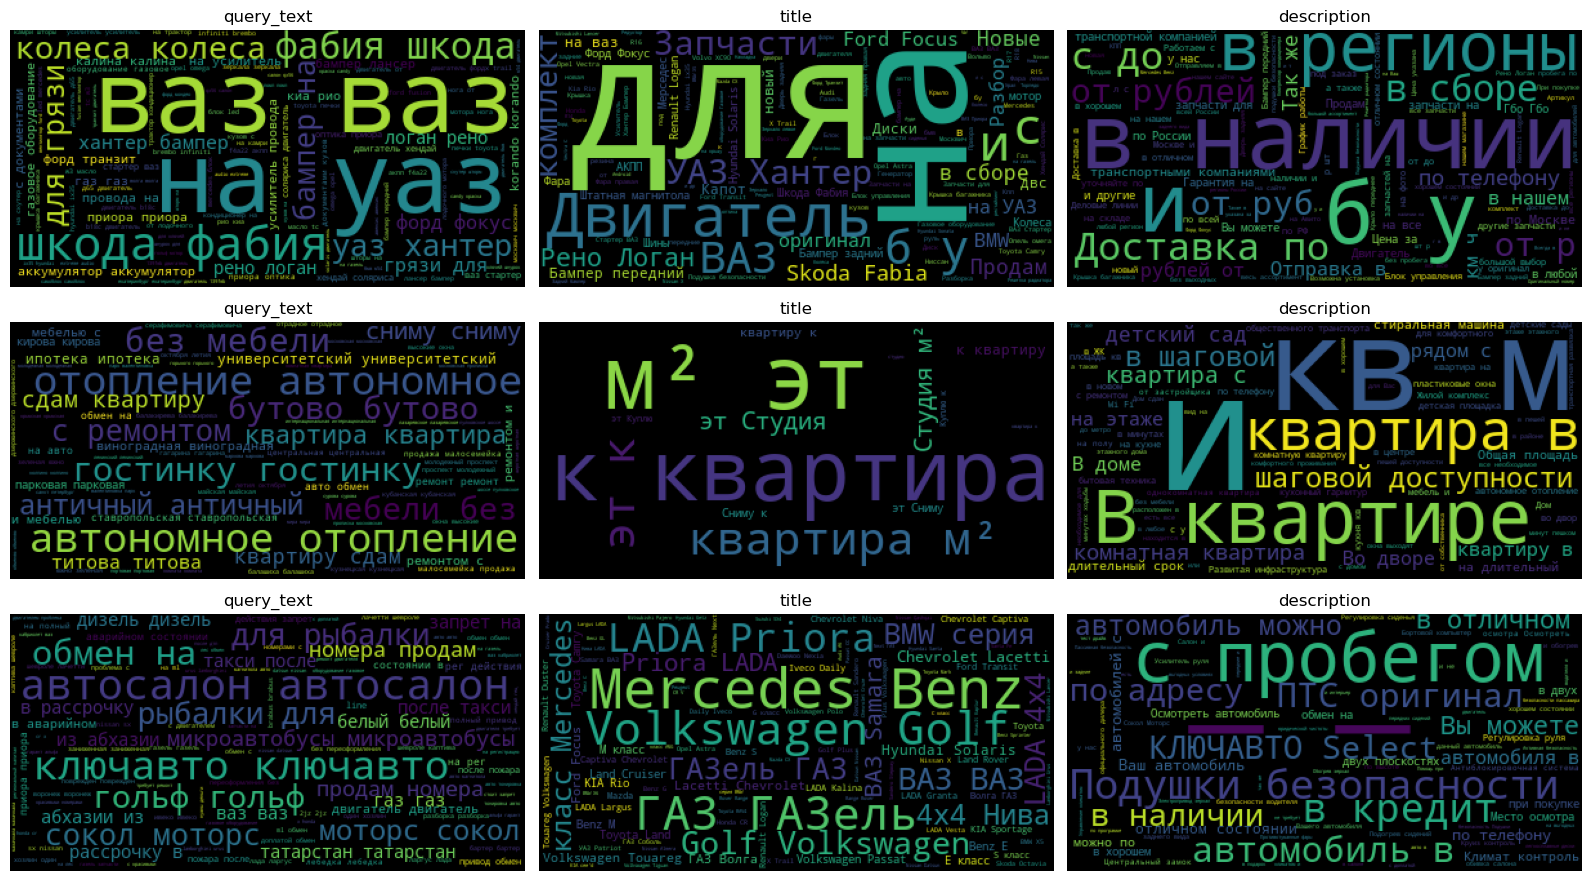

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(16, 9))

for i, cid in enumerate(df.query_category_id.value_counts().index[1:4]):
    wordcloud_i = WordCloud().generate(' '.join(df.loc[df.query_category_id == cid, 'query_text'].tolist()))
    wordcloud_q = WordCloud().generate(' '.join(df.loc[df.query_category_id == cid, 'title'].tolist()))
    wordcloud_d = WordCloud().generate(' '.join(df.loc[df.query_category_id == cid, 'description'].tolist()))

    ax[i, 0].imshow(wordcloud_i)
    ax[i, 0].axis('off')
    ax[i, 0].set_title('query_text')

    ax[i, 1].imshow(wordcloud_q)
    ax[i, 1].axis('off')
    ax[i, 1].set_title('title')

    ax[i, 2].imshow(wordcloud_d)
    ax[i, 2].axis('off')
    ax[i, 2].set_title('description')

fig.tight_layout(pad=1)

We clearly see that themes in queries and titles-descriptions are similar, have the same topic. Moreover, categories 9 and 10 look similar between each other (in both cases the most popular words imply the car theme), probably the closeness of ids have sense.

In [9]:
df.query_microcat_id.value_counts()

nan       108458
14.0        5574
30.0        3737
17.0        2325
61.0        2086
           ...  
4900.0         1
7552.0         1
5498.0         1
4842.0         1
802.0          1
Name: query_microcat_id, Length: 396, dtype: int64

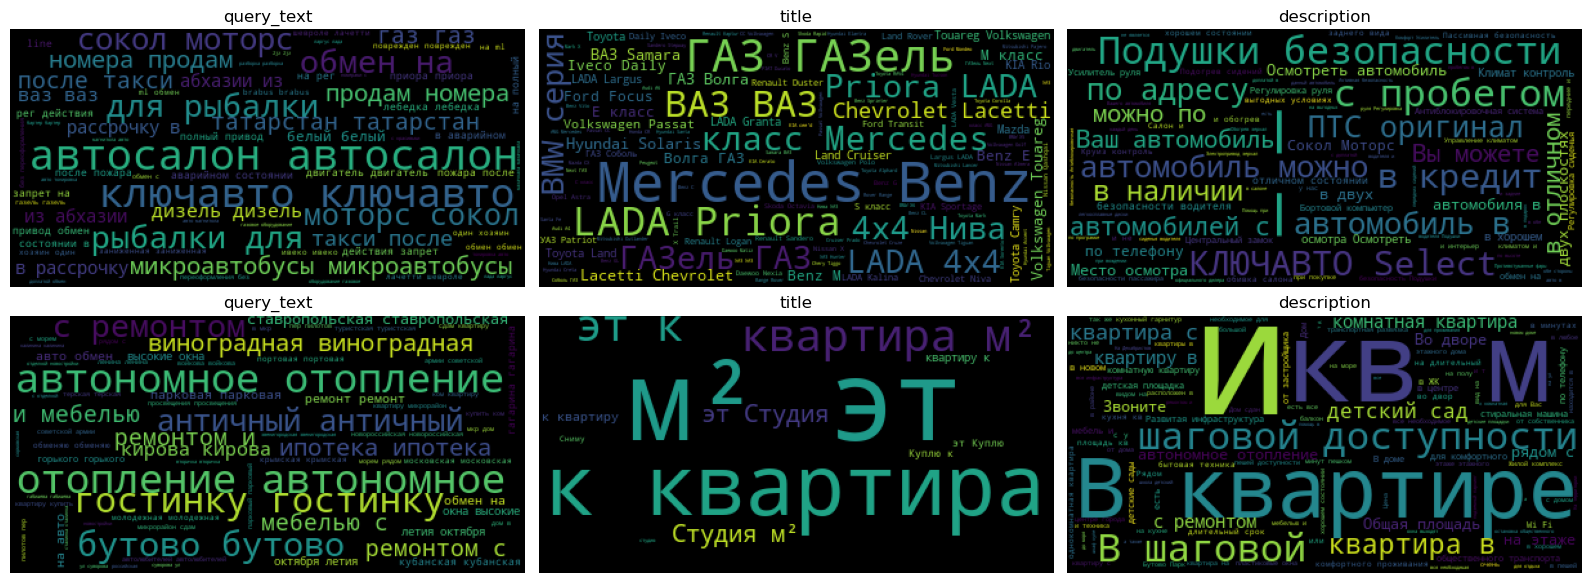

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(16, 6))

for i, cid in enumerate(df.query_microcat_id.value_counts().index[1:3]):
    wordcloud_i = WordCloud().generate(' '.join(df.loc[df.query_microcat_id == cid, 'query_text'].tolist()))
    wordcloud_q = WordCloud().generate(' '.join(df.loc[df.query_microcat_id == cid, 'title'].tolist()))
    wordcloud_d = WordCloud().generate(' '.join(df.loc[df.query_microcat_id == cid, 'description'].tolist()))

    ax[i, 0].imshow(wordcloud_i)
    ax[i, 0].axis('off')
    ax[i, 0].set_title('query_text')

    ax[i, 1].imshow(wordcloud_q)
    ax[i, 1].axis('off')
    ax[i, 1].set_title('title')

    ax[i, 2].imshow(wordcloud_d)
    ax[i, 2].axis('off')
    ax[i, 2].set_title('description')

fig.tight_layout(pad=1)

Generally, the conclusion is the same here. Probably, we should consider only one of these id columns as including both of them looks redundant.

In [11]:
df.query_id = df.query_id.astype(int)
df.drop(columns=['query_category_id', 'query_microcat_id', 'query_location_id'], inplace=True)
df.head(3)

,query_id,query_text,title,description,keywords,target
0,274025,2108 ссср,Советские бутыли канистры 60-80-х СССР ваз газ...,Для ценителей и понимающих.\n\nПодробные фотог...,стопсфинксstop,0
1,274025,2108 ссср,Ваз 2108 СССР цвет салатовый 1/43 идеальный,красивый салатовый цвет\nвсе детали в наличии\...,модель,1
2,274025,2108 ссср,Модели советских машин ваз 2102 почта М 1/43 №10,Продается модель автомобиля ВАЗ 2102 почта . ...,модель,1


Let's look at lengths of string columns:

In [12]:
df.loc[:, 'query_text':'keywords'].apply(lambda t: t.apply(len)).describe()

,query_text,title,description,keywords
count,161429.000000,161429.000000,161429.000000,161429.000000
mean,14.236494,28.894040,754.014520,22.937521
std,6.675478,12.834127,793.668851,16.136598
min,1.000000,1.000000,0.000000,0.000000
25%,9.000000,19.000000,165.000000,10.000000
50%,14.000000,29.000000,450.000000,19.000000
75%,18.000000,40.000000,1086.000000,32.000000
max,54.000000,50.000000,15448.000000,105.000000


Description expectedly has much longer texts. Now check number of words in all values:

In [13]:
df.loc[:, 'query_text':'keywords'].apply(lambda t: t.str.split().apply(len)).describe()

,query_text,title,description,keywords
count,161429.000000,161429.000000,161429.000000,161429.000000
mean,2.314708,4.580478,105.662372,2.642970
std,1.028110,2.154828,112.622406,2.080023
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,3.000000,24.000000,1.000000
50%,2.000000,5.000000,63.000000,2.000000
75%,3.000000,6.000000,150.000000,3.000000
max,9.000000,16.000000,2047.000000,15.000000


Query text in average has shorter content.

In [14]:
df.query_id.value_counts()

17134     556
17129     505
17132     488
17175     468
17128     365
         ... 
2566        1
84515       1
256880      1
2554        1
5665        1
Name: query_id, Length: 12345, dtype: int64

Sample some seperate queries.

In [15]:
df.loc[df.query_id.isin([17134]), 'query_text':].sort_values('target')

,query_text,title,description,keywords,target
112530,гантели,Скамья регулируемая со стойками papasport AR004,Технические характеристики Скамья регулируемая...,фитнес тренажер,0
112526,гантели,Гантели,"Гантели, звонить вечером после 16 часов",фитнес тренажер,1
112893,гантели,Гантель,Гантель\n \nГантель виниловая STARFIT DB-101 D...,фитнес тренажер,1
112894,гантели,Гантели,Гантели Разборная 10 кг с кейсом новые,фитнес тренажер,1
112895,гантели,Гантели,Гантели вес 20 кг в кейсе.\nОтдельно есть 4 бл...,фитнес тренажер,1
...,...,...,...,...,...
112713,гантели,Гантели,"Гантель ""Bradex"", обрезиненная, цвет: красный,...",фитнес тренажер,1
112714,гантели,Гантели,"Гантели.Без торга.Вес одной,10 кг.",фитнес тренажер,1
112715,гантели,Гантели,Гантели по 1 кг,фитнес тренажер,1
112709,гантели,Гантели,Гантели б/у некрашеные по 15 кг. разборные. 1...,фитнес тренажер,1


In [16]:
df.loc[df.query_id.isin([6363]), 'query_text':].sort_values('target')

,query_text,title,description,keywords,target
100554,маз,Газ Валдай 3310 2014г,"/0186/220/ ГАЗ 3310 - тентованный 2014г.в., 15...",грузовик,0
100508,маз,Кран-Манипулятор xiab 166XS на базе маз 6303,МАЗ 2007г двигатель 7511 400л.с 239 коробка ...,грузовик,0
100552,маз,Маз-54329,Cедельный тягач Маз-54329 \n \nДвигатель - ЯМЗ...,грузовик,1
100551,маз,Маз,Продам МАЗ 2001 г.в.,грузовик,1
100550,маз,Маз,"Продаётся МАЗ 64229-032, 1993 г выпуска. После...",грузовик,1
...,...,...,...,...,...
100504,маз,"Маз, грузовой-бортовой, категории С",МАЗ грузовой-бортовой категории С с прицепом 2...,грузовик,1
100503,маз,ЗИЛ 130гя,"Продается ЗиЛ в рабочем состоянии,на полном хо...",грузовик,1
100502,маз,Маз,Возможна продажа в кредит без справок и поручи...,грузовик,1
100514,маз,Маз 4571Р2 сельхозник самосвал новый в наличии,Продается новый МАЗ-4571Р2-435-000\n \nПТС - 2...,грузовик,1


In [17]:
df.loc[df.query_id.isin([17161]), 'query_text':].sort_values('target')

,query_text,title,description,keywords,target
108658,замена микрофона ксяоми,Xiaomi Redmi Note 6 Pro 4/64,Продам отличный камерофон - снимает фото и вид...,xiaomi,0
108653,замена микрофона ксяоми,Xiaomi mi2s 32Gb в отличном состоянии,Достоинства:\nКачество сборки.\nСоотношение це...,xiaomi,0
108652,замена микрофона ксяоми,Xiaomi yi 4k,"бу, не пишет звук, все остальное работает! со ...",камера,0
108651,замена микрофона ксяоми,Замена разъема Xiaomi Mi 5s,"Все ЦЕНЫ (включая диагностику, работу, запчаст...",аксессуар запчасть,0
108691,замена микрофона ксяоми,Микрофон для iPhone (Заменим бесплатно),Перестал работать микрофон (Вас не слышно) или...,аксессуар запчасть,0
...,...,...,...,...,...
108647,замена микрофона ксяоми,Ремонт Xiaomi Meizu Huawei Nokia LG,"Производим ремонт: замена дисплея,замена задне...",ремонт обслуживание техник мобильный устройство,1
108645,замена микрофона ксяоми,"Ремонт телефонов Xiaomi, Сяоми","5,0 ⭐️⭐️⭐️⭐️⭐️ \n \nРемонт телефонов Xiaomi, С...",ремонт обслуживание техник мобильный устройство,1
108644,замена микрофона ксяоми,Замена или ремонт камеры на iPhone и др,"Перестала работать основная, либо фронтальная ...",ремонт обслуживание техник мобильный устройство,1
108657,замена микрофона ксяоми,Профессиональный ремонт телефонов. Гарантия 2м...,СПЕЦИАЛИЗИРОВАННЫЙ СЕРВИСНЫЙ ЦЕНТР \nоказывает...,ремонт обслуживание техник мобильный устройство,1


The example above demonstrates that simple matching doesn't work in some cases, for example Xiaomi and ксяоми are not equal precisely, but it's obvious that it's the same if we ignore transliteration. In such cases probably embeddings on substrings can learn the content.

In [18]:
df.loc[df.query_id.isin(df.query_id.sample(1, random_state=42)), 'query_text':].sort_values('target')

,query_text,title,description,keywords,target
145102,zalman n3,"I7-6700к, evga GTX 1080 8Gb gddr5X",Комп на гарантии с большим заделом на будущее!...,,0
145132,zalman n3,"Игровой компьютер 1060,16 озу,ssd 240",СРОЧНО!!!\nДо конца недели за 20000\nпосле 220...,,0
145134,zalman n3,Компьютер,Комплектующие:\nGTX 1060 6gb\nRyzen 2600\nAsus...,,0
145137,zalman n3,Мощный игровой пк на Ryzen. Только 2 дня,Продам. Только три дня. До конца недели. Без т...,,0
145138,zalman n3,Сист.блок i5/RAM16Gb/SSD120Gb/HDD2Tb/GTX1660 6Gb,Продам игровой системный блок. Идут все соврем...,,0
...,...,...,...,...,...
145135,zalman n3,Системный блок Zalman N3,Продаю системный блок\n-Мат.плата PLEXHDx79 Tu...,,1
145126,zalman n3,Игровой компьютер,* Корпус ATX ZALMAN N3\n* Материнская плата AS...,,1
145133,zalman n3,Компьютер игровой,Игровой компьютер:\nПроцессор: Intel core i7\n...,,1
145129,zalman n3,Zalman n3,Нужно поменять окно 100 рублей на рынке.\nНабо...,аксессуар,1


Let's try a very simple baseline to check if we have seperability between 0 and 1 cases:
1. Learn TF-IDF (on queries and titles)
2. Get TF-IDF vectors for query and title
3. Calculate cosine similarity and use it like ranking metric

In [19]:
def cosine_similarity(X_q, X_i):
    q_i_dot = (X_q.multiply(X_i)).sum(axis=1)
    q_norm_2 = (X_q.multiply(X_q)).sum(axis=1)
    i_norm_2 = (X_i.multiply(X_i)).sum(axis=1)

    return np.squeeze(np.asarray(q_i_dot)) / (np.squeeze(np.asarray(q_norm_2))**0.5 * np.squeeze(np.asarray(i_norm_2))**0.5 + 1e-7)

We use GroupKFold as we can't see the part of response for user: it's all or nothing.

In [20]:
%%time

kf = GroupKFold(n_splits=5)

for train_indices, test_indices in kf.split(X=df, groups=df.query_id):
    df_train, df_test = df.loc[train_indices], df.loc[test_indices]
    print('-' * 80)
    print('Train:', df_train.shape, df_train.query_id.nunique(), '  ',
          'Test:', df_test.shape, df_test.query_id.nunique(), '  ',
          'Intersection:', set(df_train.query_id).intersection(set(df_test.query_id))); print()

    tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2, 7), min_df=25, max_df=0.99)
    tfidf.fit(pd.concat([df_train.query_text, df_train.title], axis=0))
    print('Vocabulary size:', len(tfidf.vocabulary_))

    X_q, X_i = tfidf.transform(df_train.query_text), tfidf.transform(df_train.title)
    cos_sim = cosine_similarity(X_q, X_i)

    print(f'ROC-AUC train: {roc_auc_score(df_train.target.values, cos_sim):.3f}')

    X_q, X_i = tfidf.transform(df_test.query_text), tfidf.transform(df_test.title)
    cos_sim = cosine_similarity(X_q, X_i)

    print(f'ROC-AUC test: {roc_auc_score(df_test.target.values, cos_sim):.3f}'); print('-' * 80); print()

--------------------------------------------------------------------------------
Train: (129143, 6) 9876    Test: (32286, 6) 2469    Intersection: set()

Vocabulary size: 108832
ROC-AUC train: 0.700
ROC-AUC test: 0.726
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Train: (129143, 6) 9876    Test: (32286, 6) 2469    Intersection: set()

Vocabulary size: 108944
ROC-AUC train: 0.701
ROC-AUC test: 0.724
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Train: (129143, 6) 9876    Test: (32286, 6) 2469    Intersection: set()

Vocabulary size: 109047
ROC-AUC train: 0.712
ROC-AUC test: 0.682
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Train: (129143, 

We see that in all folds we have ROC-AUC much higher than 0.5, so it's possible to show more relevant items than simply random.

This baseline has pros and cons, but this is a story for the new notebook :)